# Análise de Série Temporal de PASSO_REAL
Este notebook apresenta a separação do código original em seções documentadas para facilitar a leitura e manutenção.

## Resolvendo problema com dependências

In [1]:
# (re)instala numpy na versão compatível
%pip install numpy==1.26.4

# depois instala/reinstala as outras dependências
%pip install pandas~=2.2.3 \ seaborn~=0.13.2 \ matplotlib~=3.10.1 \ statsmodels~=0.14.4 \ pmdarima~=2.0.4 \ openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Directory '\\' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


## 1. Imports e Leitura de Dados

In [2]:
# =======================
# 1. Imports e Configurações
# =======================
import pmdarima as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Carregar o dataset
df_raw = pd.read_excel('PASSO_REAL.xlsx')

## 2. Pré-processamento

In [9]:
df_raw.head()

,ANO,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ
0,1931,96,30,53,49,239,271,291,153,133,86,97,77
1,1932,60,78,77,398,292,189,294,270,345,234,112,97
2,1933,58,77,86,43,65,104,86,141,176,171,45,21
3,1934,32,211,101,141,233,288,196,178,231,180,100,87
4,1935,62,58,60,58,54,183,340,317,345,480,167,277


In [10]:
def modify_dataframe(dataframe):
    dataframe = dataframe.melt(id_vars='ANO', var_name='MONTH', value_name='VALUE')
    month_map = {
        'JAN': '01', 'FEV': '02', 'MAR': '03', 'ABR': '04',
        'MAI': '05', 'JUN': '06', 'JUL': '07', 'AGO': '08',
        'SET': '09', 'OUT': '10', 'NOV': '11', 'DEZ': '12'
    }
    dataframe['MONTH'] = dataframe['MONTH'].map(month_map)
    dataframe['DATE'] = dataframe['ANO'].astype(str) + '-' + dataframe['MONTH']
    dataframe = dataframe[['DATE', 'VALUE']].sort_values(by='DATE').reset_index(drop=True)
    return dataframe

# Aplicar transformação
df = modify_dataframe(df_raw)

In [11]:
df.head()

,DATE,VALUE
0,1931-01,96
1,1931-02,30
2,1931-03,53
3,1931-04,49
4,1931-05,239


## 3. Visualização

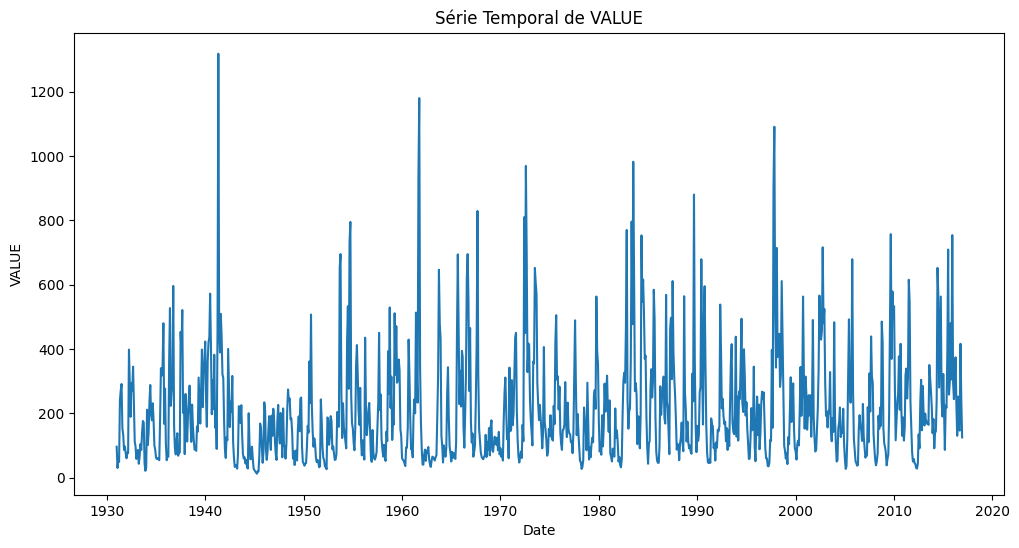

In [15]:
def plot_time_series(dataframe):
    dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
    dataframe.set_index('DATE', inplace=True)
    plt.figure(figsize=(12, 6))
    plt.plot(dataframe['VALUE'])
    plt.title('Série Temporal de VALUE')
    plt.ylabel('VALUE')
    plt.xlabel('Date')
    plt.show()

# Plotar série temporal
plot_time_series(df.copy())

### Boxplot por Ano e por Mês

C:\Users\joaog\AppData\Local\Temp\ipykernel_4612\3384275694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


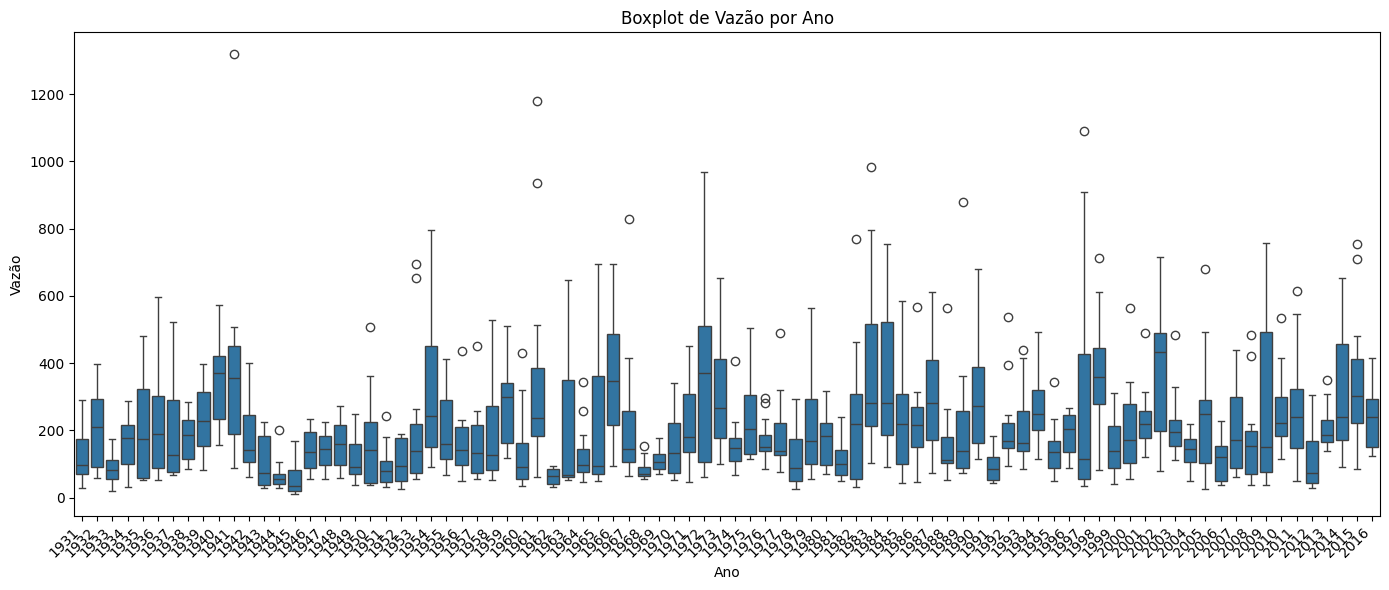

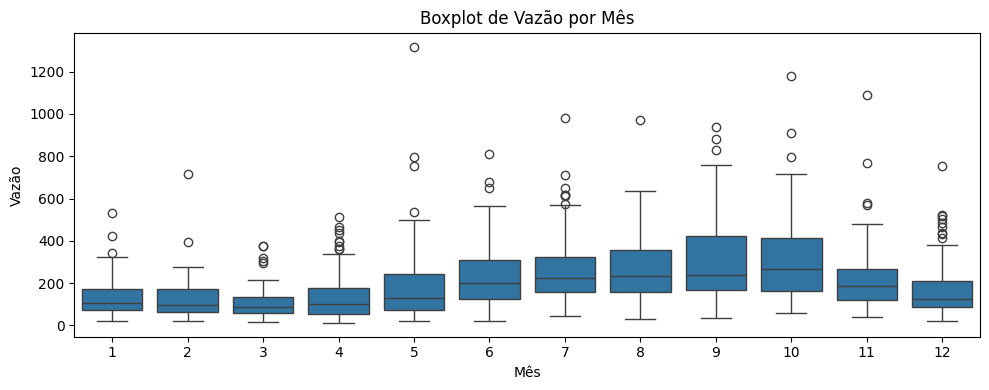

In [16]:
def year_month_boxplots(dataframe):
    # garante DatetimeIndex
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
        dataframe.set_index('DATE', inplace=True)

    dataframe['YEAR'] = dataframe.index.year
    dataframe['MONTH'] = dataframe.index.month

    # --- Boxplot por Ano ---
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(x='YEAR', y='VALUE', data=dataframe.reset_index(), ax=ax)
    ax.set_title('Boxplot de Vazão por Ano')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Vazão')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Boxplot por Mês ---
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x='MONTH', y='VALUE', data=dataframe.reset_index(), ax=ax)
    ax.set_title('Boxplot de Vazão por Mês')
    ax.set_xlabel('Mês')
    ax.set_ylabel('Vazão')
    # rótulos de mês permanecem horizontais
    plt.tight_layout()
    plt.show()

# Gerar boxplots
year_month_boxplots(df.copy())

## 4. Teste de Estacionaridade, Decomposição, Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

### 4.1. Teste de Estacionaridade

In [17]:
# Teste de raiz unitária (Dickey–Fuller)
result = adfuller(df['VALUE'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.528973
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### 4.2. Decomposição Sazonal

Decomposição Multiplicativa


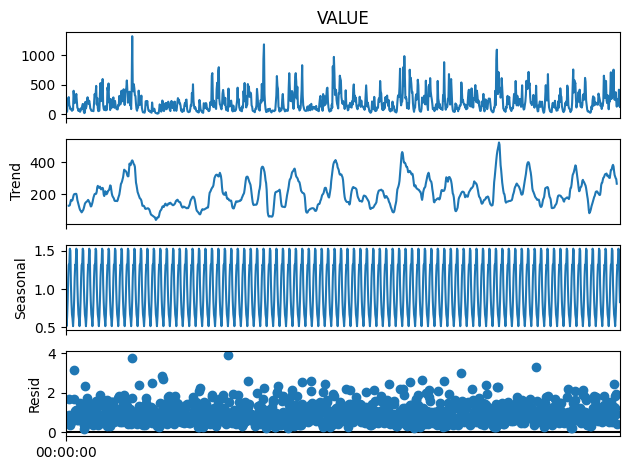

Decomposição Aditiva


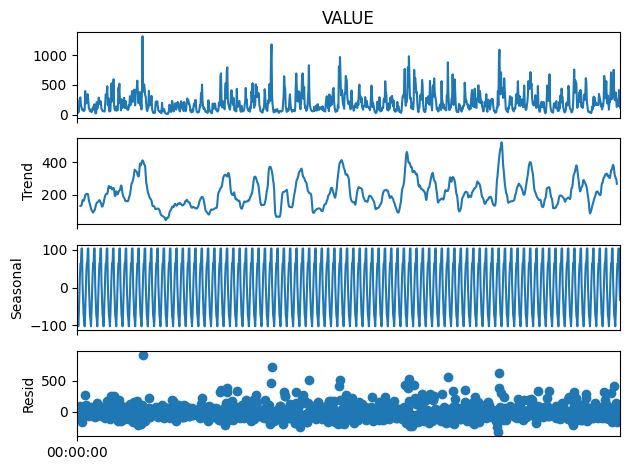

In [18]:
# Decomposição sazonal
print('Decomposição Multiplicativa')
df.index = pd.to_datetime(df.index)
decomp = seasonal_decompose(df['VALUE'], model='multiplicative', period=12)
decomp.plot()
plt.show()
print('Decomposição Aditiva')
decomp_add = seasonal_decompose(df['VALUE'], model='additive', period=12)
decomp_add.plot()
plt.show()

### 4.3. Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

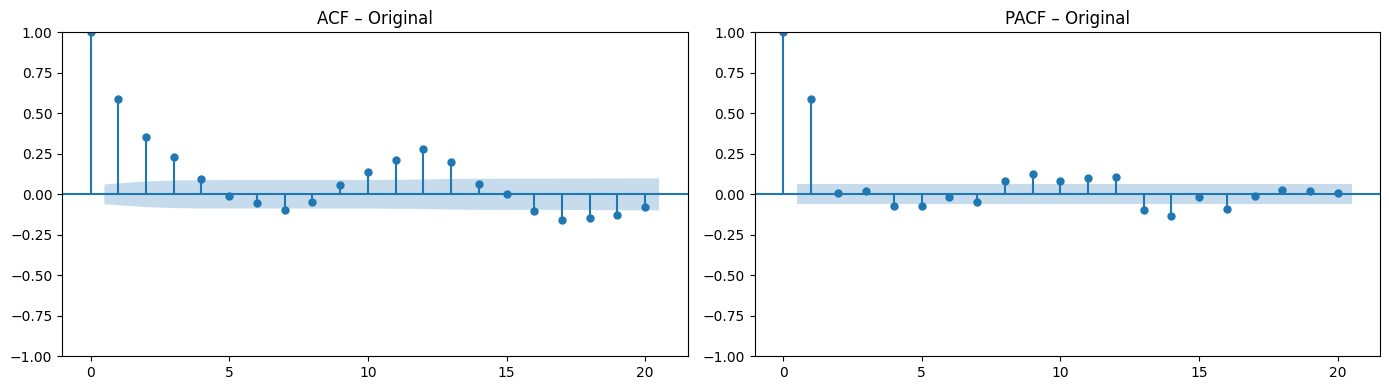

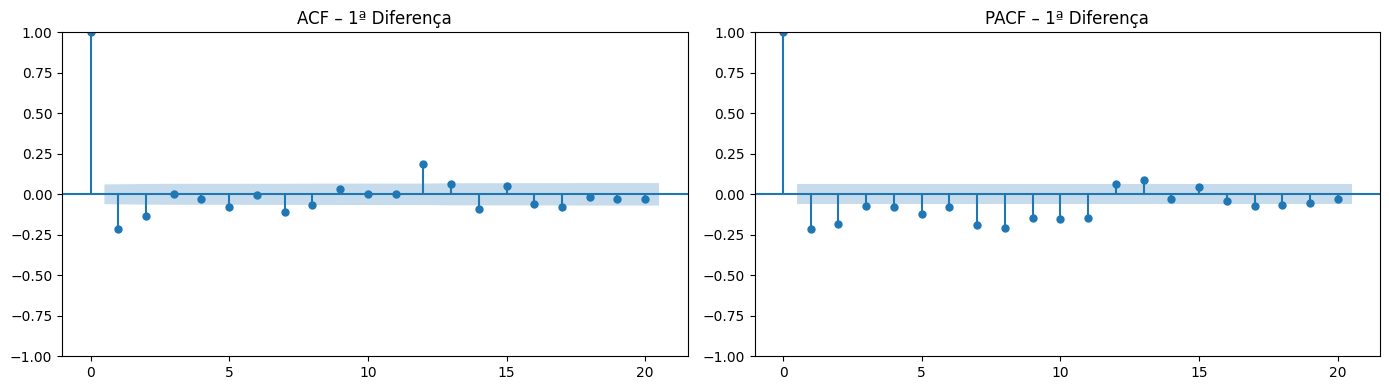

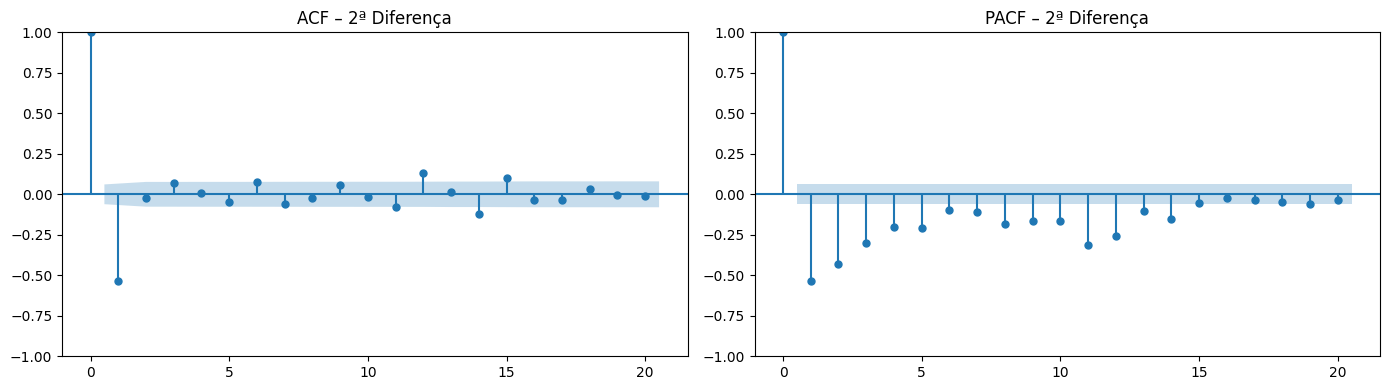

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# --- prepara as séries ---
serie_orig   = df['VALUE'].dropna()
serie_diff1  = df['VALUE'].diff().dropna()
serie_diff2  = df['VALUE'].diff().diff().dropna()

# lags a usar
nlags = 20

# --- ACF/PACF para cada caso ---
for nome, serie in [
    ('Original', serie_orig),
    ('1ª Diferença', serie_diff1),
    ('2ª Diferença', serie_diff2),
]:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(serie, lags=nlags, ax=axes[0])
    axes[0].set_title(f'ACF – {nome}')
    plot_pacf(serie, lags=nlags, ax=axes[1])
    axes[1].set_title(f'PACF – {nome}')
    plt.tight_layout()
    plt.show()


## 5. Modelagem ARMA (p, q)

In [20]:
import warnings

# 1) Ignora os UserWarning do pmdarima (m set for non-seasonal)
warnings.filterwarnings(
    "ignore",
    message="m \\(.*\\) set for non-seasonal fit.*",
    category=UserWarning
)

# 2) Ignora os FutureWarning do sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

# (Opcional) Se quiser suprimir todo e qualquer aviso:
warnings.filterwarnings("ignore")

In [21]:
# --------------------------------------------------
# ARMA(p,0,q) com split 1931–2010 treino / 2011–2016 teste
# --------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1) Cópia do df já carregado e pré-processado
df_arma = df.copy()

# (Se ainda não tiver freq mensal, descomente:)
df_arma['DATE'] = pd.to_datetime(df_arma['DATE'], format='%Y-%m')
df_arma.set_index('DATE', inplace=True)
df_arma.index = pd.DatetimeIndex(df_arma.index.values, freq='MS')

# 2) Split por período
train = df_arma['VALUE']['1931-01-01':'2010-12-01']
test  = df_arma['VALUE']['2011-01-01':'2016-12-01']

# 3) Grid search ARMA(p,0,q) mínimo AIC sobre treino
best_aic = np.inf
best_order = None
best_model = None

for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(train, order=(p, 0, q))
            fit = model.fit()
            if fit.aic < best_aic:
                best_aic    = fit.aic
                best_order  = (p, 0, q)
                best_model  = fit
        except Exception:
            continue

print(f"Melhor ARMA order: {best_order} | AIC = {best_aic:.2f}")
print(best_model.summary())

Melhor ARMA order: (5, 0, 4) | AIC = 12085.53
                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                  960
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -6031.767
Date:                Mon, 05 May 2025   AIC                          12085.533
Time:                        16:57:17   BIC                          12139.069
Sample:                    01-01-1931   HQIC                         12105.921
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.9371     15.454     13.326      0.000     175.647     236.227
ar.L1          1.2812      0.031     40.872      0.000       1.220       1.343
ar.L2 

In [22]:
# --------------------------------------------------
# Ajuste ARMA(p,0,q) via SARIMAX e Forecast limpo
# Treino: 1931–2010 | Teste: 2011–2016
# --------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Prepare uma cópia limpa e com freq mensal
df_model = df.copy()
df_model.index = pd.to_datetime(df_model.index)      # já deve ser 'YYYY-MM'
df_model = df_model.asfreq('MS')                     # MS = Month Start :contentReference[oaicite:1]{index=1}

df_model.head()

,DATE,VALUE
1970-01-01,1931-01,96


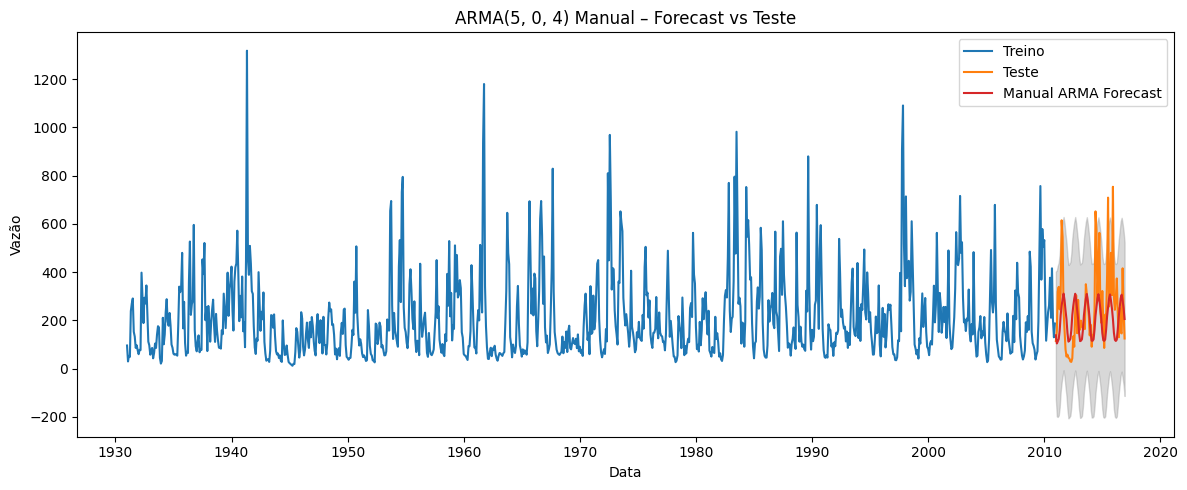

In [23]:
# 1) Cópia do df e configuração do índice
df_model = df.copy()
df_model['DATE'] = pd.to_datetime(df_model['DATE'], format='%Y-%m')
df_model.set_index('DATE', inplace=True)
df_model.index = pd.DatetimeIndex(df_model.index.values, freq='MS')

# 2) Split Treino (1931–2010) / Teste (2011–2016)
train = df_model['VALUE']['1931-01-01':'2010-12-01']
test  = df_model['VALUE']['2011-01-01':'2016-12-01']

# --------------------------
# 3) Modelo ARMA usando o ARIMA, assim como na documentação:
# https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html
# --------------------------
manual_model = ARIMA(train, order=(5, 0, 4)).fit()

# Forecast sobre o teste
manual_fc_obj = manual_model.get_forecast(steps=len(test))
manual_fc_arma     = manual_fc_obj.predicted_mean
manual_ci     = manual_fc_obj.conf_int(alpha=0.05)

# Plot Forecast vs Teste
plt.figure(figsize=(12, 5))
plt.plot(train, label='Treino')
plt.plot(test,  label='Teste')
plt.plot(manual_fc_arma, label='Manual ARMA Forecast', color='tab:red')
plt.fill_between(manual_ci.index,
                 manual_ci.iloc[:,0],
                 manual_ci.iloc[:,1],
                 color='gray', alpha=0.3)
plt.title('ARMA(5, 0, 4) Manual – Forecast vs Teste')
plt.xlabel('Data')
plt.ylabel('Vazão')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

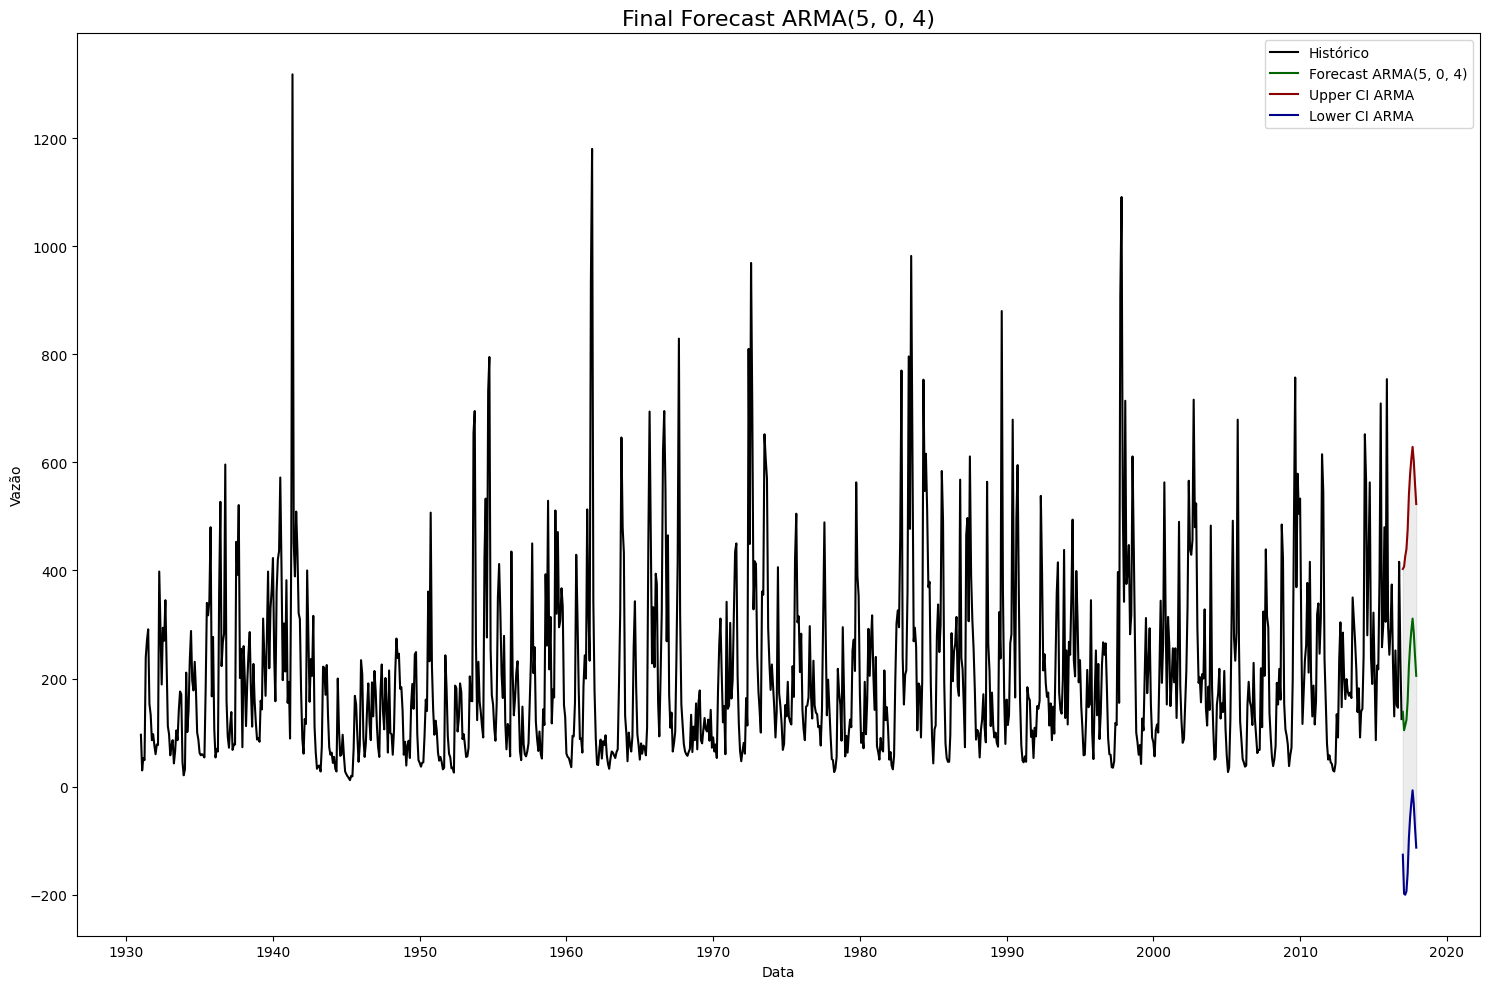

In [25]:
# --------------------------------------------------
# Forecast ARMA(p,0,q) – mesmo estilo do ARIMA
# --------------------------------------------------

# 1) Quantos passos à frente
n_forecast = 12

# 2) Gera forecast via arma_mod
fc_arma_obj       = manual_model.get_forecast(steps=n_forecast)
fc_series_arma    = fc_arma_obj.predicted_mean
ci_arma           = fc_arma_obj.conf_int(alpha=0.05)
lower_series_arma = ci_arma.iloc[:, 0]
upper_series_arma = ci_arma.iloc[:, 1]

# 3) Índice de datas futuro (próximo mês em diante)
last_date       = df_model.index[-1]
future_index    = pd.date_range(
    last_date + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq='MS'
)

# 4) Ajusta índice das séries de forecast e CI
fc_series_arma.index    = future_index
lower_series_arma.index = future_index
upper_series_arma.index = future_index

# 5) Plot no mesmo formato do ARIMA
figure(figsize=(15,10))

# Série histórica
plt.plot(df_model['VALUE'], label='Histórico', color='black')

# Forecast ARMA
plt.plot(fc_series_arma,    color='darkgreen', label=f'Forecast ARMA{best_order}')
plt.plot(upper_series_arma, color='darkred',   label='Upper CI ARMA')
plt.plot(lower_series_arma, color='darkblue',  label='Lower CI ARMA')

# Banda de confiança
plt.fill_between(
    future_index,
    lower_series_arma,
    upper_series_arma,
    color='gray',
    alpha=0.15
)

plt.title(f"Final Forecast ARMA{best_order}", fontsize=16)
plt.xlabel("Data")
plt.ylabel("Vazão")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Modelagem ARIMA (p, d=1, q)

In [26]:
# --------------------------------------------------
# ARIMA Manual e auto_arima com split por período
# --------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [27]:
# 1) Cópia do df e configuração do índice
df_model = df.copy()
df_model['DATE'] = pd.to_datetime(df_model['DATE'], format='%Y-%m')
df_model.set_index('DATE', inplace=True)
df_model.index = pd.DatetimeIndex(df_model.index.values, freq='MS')

# 2) Split Treino (1931–2010) / Teste (2011–2016)
train = df_model['VALUE']['1931-01-01':'2010-12-01']
test  = df_model['VALUE']['2011-01-01':'2016-12-01']

# --------------------------
# 3) Modelo ARIMA Manual
# --------------------------
manual_model = ARIMA(train, order=(1, 1, 2)).fit()

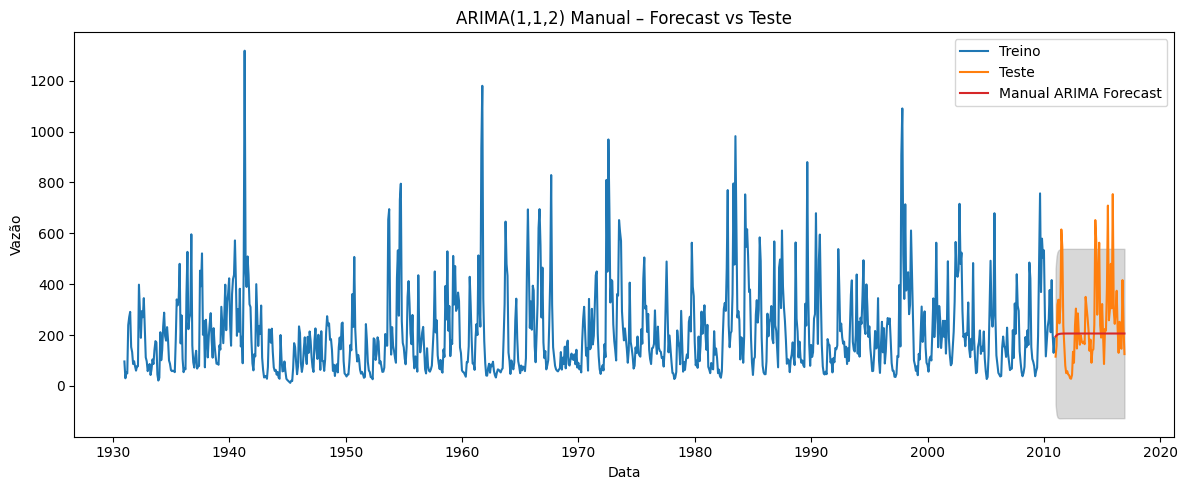

In [ ]:
# Forecast sobre o teste
manual_fc_obj = manual_model.get_forecast(steps=len(test))
manual_fc_arima     = manual_fc_obj.predicted_mean
manual_ci     = manual_fc_obj.conf_int(alpha=0.05)

# Plot Forecast vs Teste
plt.figure(figsize=(16, 9))
plt.plot(train, label='Treino')
plt.plot(test,  label='Teste')
plt.plot(manual_fc_arima, label='Manual ARIMA Forecast', color='tab:red')
plt.fill_between(manual_ci.index,
                 manual_ci.iloc[:,0],
                 manual_ci.iloc[:,1],
                 color='gray', alpha=0.3)
plt.title('ARIMA(1,1,2) Manual – Forecast vs Teste')
plt.xlabel('Data')
plt.ylabel('Vazão')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
import warnings

# 1) Ignora os UserWarning do pmdarima (m set for non-seasonal)
warnings.filterwarnings(
    "ignore",
    message="m \\(.*\\) set for non-seasonal fit.*",
    category=UserWarning
)

# 2) Ignora os FutureWarning do sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

# (Opcional) Se quiser suprimir todo e qualquer aviso:
# warnings.filterwarnings("ignore")


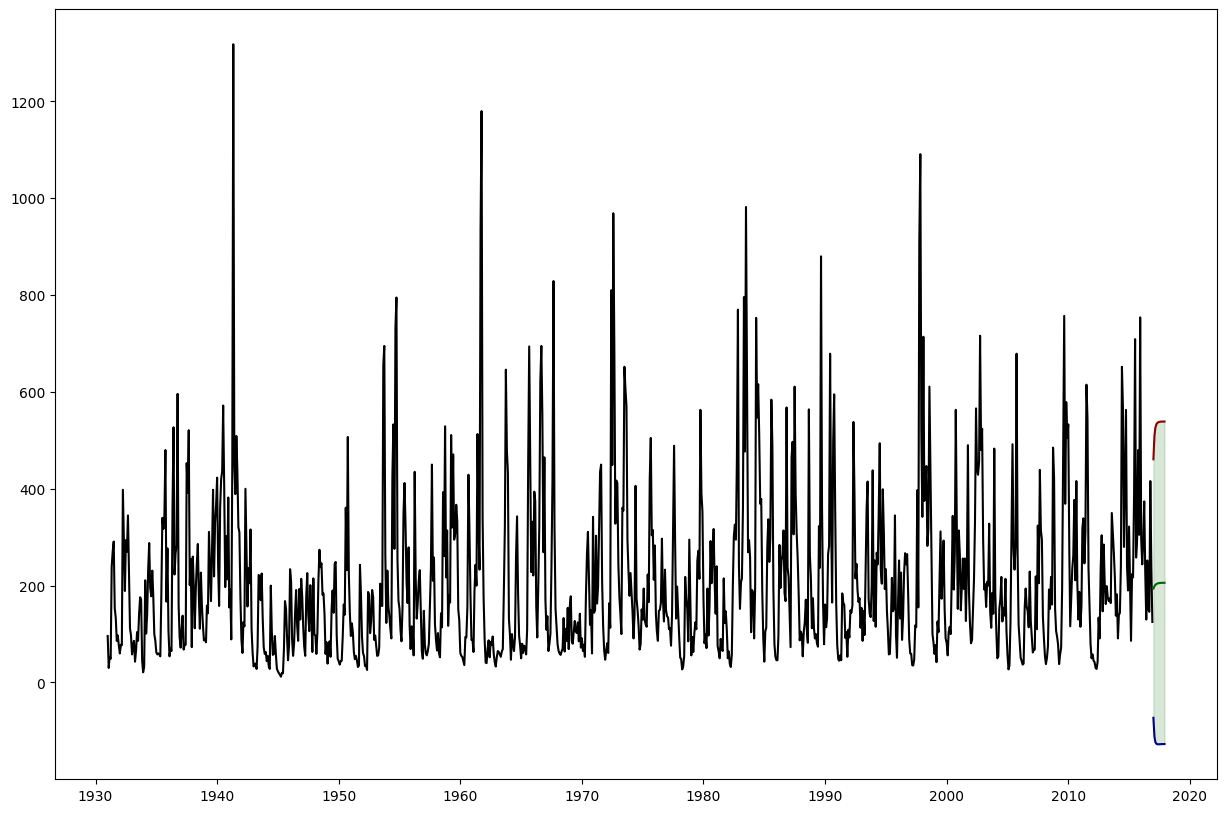

In [30]:
# 1) ARIMA(1,1,2) – usando manual_model e previsão para os próximos n_forecast passos
n_forecast = 12
fc_arima_obj = manual_model.get_forecast(steps=n_forecast)
fc_series_arima    = fc_arima_obj.predicted_mean
ci_arima           = fc_arima_obj.conf_int(alpha=0.05)
lower_series_arima = ci_arima.iloc[:, 0]
upper_series_arima = ci_arima.iloc[:, 1]

last_date = df_model.index[-1]
future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1),
                             periods=n_forecast, freq='MS')
fc_series_arima.index    = future_index
lower_series_arima.index = future_index
upper_series_arima.index = future_index

figure(figsize=(15,10))

# 1) Série histórica
plt.plot(df_model['VALUE'], label='Histórico', color='black')

# 2) Forecast ARIMA (1,1,2)
plt.plot(fc_series_arima,    color='darkgreen', label='Forecast ARIMA(1,1,2)')
plt.plot(upper_series_arima, color='darkred',   label='Upper CI ARIMA')
plt.plot(lower_series_arima, color='darkblue',  label='Lower CI ARIMA')
plt.fill_between(
    lower_series_arima.index,
    lower_series_arima,
    upper_series_arima,
    color='darkgreen',
    alpha=0.15
)

In [31]:
# --------------------------
# 4) Modelo auto_arima
# --------------------------
auto_model = pm.auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3, m=12,
    seasonal=False, d=None,
    test='adf', trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13450.786, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12297.663, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12841.764, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12280.980, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12269.073, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=3.80 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12167.304, Time=0.75 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12165.336, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12163.399, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12580.706, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12165.357, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12270.018, Time=1.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12167.337, Time=1.64 sec

Best model:  ARIMA(1,0,0)(0,0,

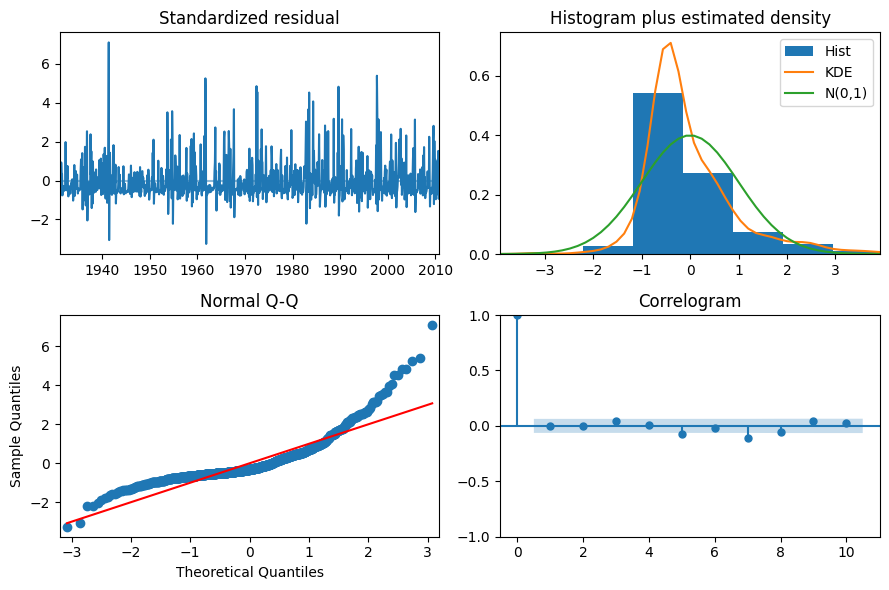

In [32]:
# Diagnóstico completo do auto_arima
auto_model.plot_diagnostics(figsize=(9, 6))
plt.tight_layout()
plt.show()

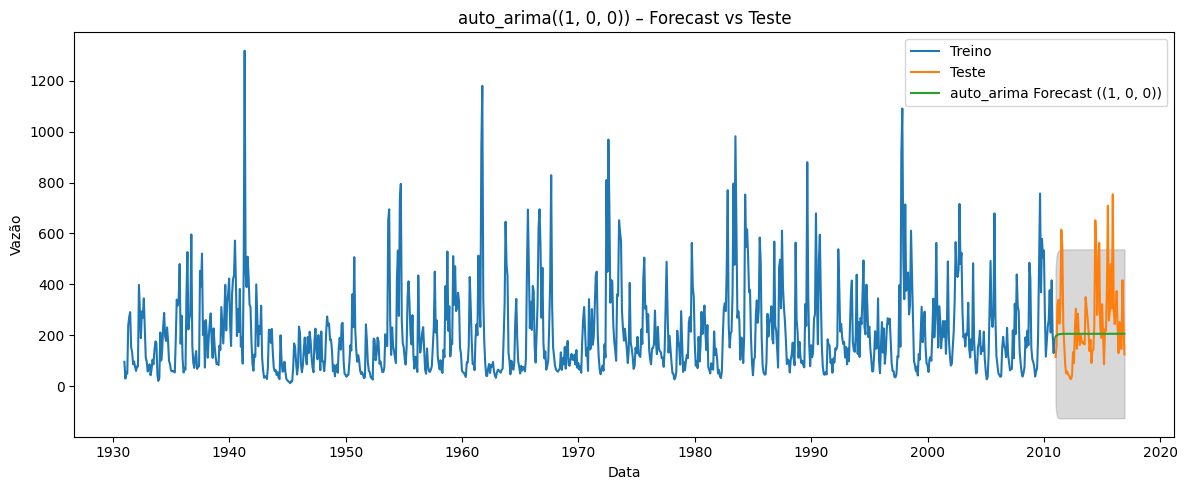

In [33]:
# Forecast sobre o teste
fc_auto, ci_auto = auto_model.predict(
    n_periods=len(test),
    return_conf_int=True,
    alpha=0.05
)
fc_auto   = pd.Series(fc_auto, index=test.index)
ci_auto   = pd.DataFrame(ci_auto, index=test.index, columns=['lower','upper'])

# Plot Forecast auto_arima vs Teste
plt.figure(figsize=(12, 5))
plt.plot(train, label='Treino')
plt.plot(test,  label='Teste')
plt.plot(fc_auto, label=f'auto_arima Forecast ({auto_model.order})', color='tab:green')
plt.fill_between(ci_auto.index,
                 ci_auto['lower'],
                 ci_auto['upper'],
                 color='gray', alpha=0.3)
plt.title(f'auto_arima({auto_model.order}) – Forecast vs Teste')
plt.xlabel('Data')
plt.ylabel('Vazão')
plt.legend()
plt.tight_layout()
plt.show()


## 7. Modelagem SARIMA (p, d=1, q) (P, D=1, Q)m = 12

In [34]:
sarima = pm.auto_arima(
    train, start_p=1,
    d=1, start_q=1,
    start_P=0, D=1,
    max_p=3, max_q=3,
    m=12, test='adf',
    seasonal=True, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)
print(sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12663.597, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12356.859, Time=2.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=8.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12568.531, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12272.793, Time=5.95 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=18.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12355.986, Time=2.90 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12223.895, Time=5.77 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=12309.867, Time=3.69 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=43.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.35 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=12203.693, Time=6.92 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

Text(0.5, 1.0, 'SARIMA')

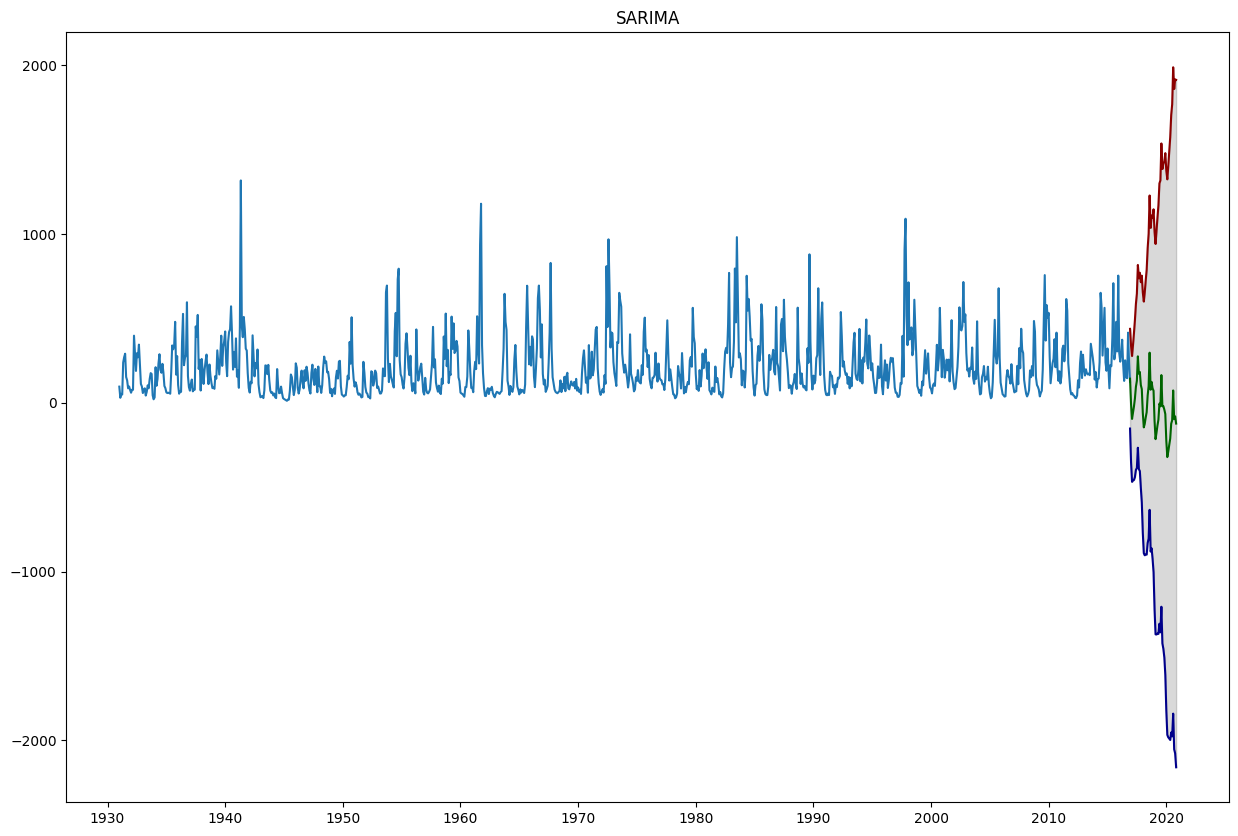

In [35]:
figure(figsize=(15,10))
n_periods = 48
fitted, confint = sarima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_model.index[-1], periods = n_periods, freq='MS')
# make series for plotting purpose
fitted_series_sarima = pd.Series(fitted.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
# Plot
plt.plot(df_model)
plt.plot(fitted_series_sarima, color='darkgreen')
plt.plot(upper_series, color='darkred')
plt.plot(lower_series, color='darkblue')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMA")

## 8. Análise a Precisão dos Modelos com EPMA (Erro Percentual Médio Absoluto)

In [36]:
from sklearn.metrics import mean_absolute_percentage_error

def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [37]:
mape = calculate_mape(test, manual_fc_arma)
print(f'Model Precision (MAPE): {mape:.2f}%')

Model Precision (MAPE): 66.76%


In [38]:
mape = calculate_mape(test, manual_fc_arima)
print(f'Model Precision (MAPE): {mape:.2f}%')

Model Precision (MAPE): 76.48%


In [39]:
mape = calculate_mape(test, fitted_series_sarima)
print(f'Model Precision (MAPE): {mape:.2f}%')

Model Precision (MAPE): 14.37%


## 9. Análise de Erro de Persistência para Validação dos Modelos

In [130]:
def persistence_forecast(train, test, n_periods):
    
    last_season = train.iloc[-n_periods:]
    test_index = test.iloc[:n_periods].index
    persistence_forecast = pd.Series(last_season.values, index=test_index)
    
    return persistence_forecast


In [142]:
n_periods = 72
persistence_forecast(train, test, n_periods)

2011-01-01     58
2011-02-01     27
2011-03-01     35
2011-04-01    122
2011-05-01    305
             ... 
2016-08-01    211
2016-09-01    416
2016-10-01    203
2016-11-01    130
2016-12-01    187
Freq: MS, Length: 72, dtype: int64

In [143]:
train.iloc[-n_periods:]

2005-01-01     58
2005-02-01     27
2005-03-01     35
2005-04-01    122
2005-05-01    305
             ... 
2010-08-01    211
2010-09-01    416
2010-10-01    203
2010-11-01    130
2010-12-01    187
Freq: MS, Name: VALUE, Length: 72, dtype: int64

In [144]:
n_periods = 72
persistence = persistence_forecast(train, test, n_periods)
persistence_mape = calculate_mape(test, persistence)
persistence_mape

64.62072461322906

# 10. Ajustes Pós feedback do professor

## 10.1. ARMA Pós Ajuste

In [27]:
# %% --------------------------- 0. Imports e setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="m \\(.*\\) set for non-seasonal fit.*", category=UserWarning)

# %% --------------------------- 1. Carregar e preparar os dados
df_arma = df.copy()                         # <- df precisa existir antes
df_arma['DATE'] = pd.to_datetime(df_arma['DATE'], format='%Y-%m')
df_arma.set_index('DATE', inplace=True)
df_arma.index = pd.DatetimeIndex(df_arma.index.values, freq='MS')

full_series = df_arma['VALUE']

# janelas de treino / teste
start_train, end_train = '1931-01-01', '2010-12-01'
start_test,  end_test  = '2011-01-01', '2016-12-01'

train_series = full_series[start_train:end_train]
test_series  = full_series[start_test:end_test]          # <- usaremos nos plots
test_dates   = test_series.index                         # já tem freq='MS'

In [28]:
# %% --------------------------- 2. ARMA Manual
manual_order = (5, 0, 4)
manual_pred, manual_low, manual_up = [], [], []

for date in test_dates:
    train_data = full_series[:date - pd.DateOffset(months=1)]
    model = ARIMA(train_data, order=manual_order).fit()
    fc_obj = model.get_forecast(steps=1)

    manual_pred.append(fc_obj.predicted_mean.iloc[0])
    ci = fc_obj.conf_int(alpha=0.05)
    manual_low.append(ci.iloc[0, 0])
    manual_up.append(ci.iloc[0, 1])

manual_pred = pd.Series(manual_pred, index=test_dates)
manual_low  = pd.Series(manual_low,  index=test_dates)
manual_up   = pd.Series(manual_up,   index=test_dates)

# %% --------------------------- 3. auto_arima para escolher ordem (somente ARMA)
print("Rodando auto_arima (somente ARMA)…")
auto_model = auto_arima(
    train_series,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0, seasonal=False,
    stepwise=True, suppress_warnings=True,
    error_action='ignore', trace=True
)

print("\nMelhor modelo encontrado:")
print(auto_model.summary())

auto_order = auto_model.order

# %% --------------------------- 4. ARMA com a ordem do auto_arima
auto_pred, auto_low, auto_up = [], [], []

for date in test_dates:
    train_data = full_series[:date - pd.DateOffset(months=1)]
    model = ARIMA(train_data, order=auto_order).fit()
    fc_obj = model.get_forecast(steps=1)

    auto_pred.append(fc_obj.predicted_mean.iloc[0])
    ci = fc_obj.conf_int(alpha=0.05)
    auto_low.append(ci.iloc[0, 0])
    auto_up.append(ci.iloc[0, 1])

auto_pred = pd.Series(auto_pred, index=test_dates)
auto_low  = pd.Series(auto_low,  index=test_dates)
auto_up   = pd.Series(auto_up,   index=test_dates)

Rodando auto_arima (somente ARMA)…
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13450.786, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12297.663, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12841.764, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12280.980, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12269.073, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=12269.298, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=12270.565, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12167.304, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12165.336, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12163.399, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12580.706, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12165.357, Time=0.07 

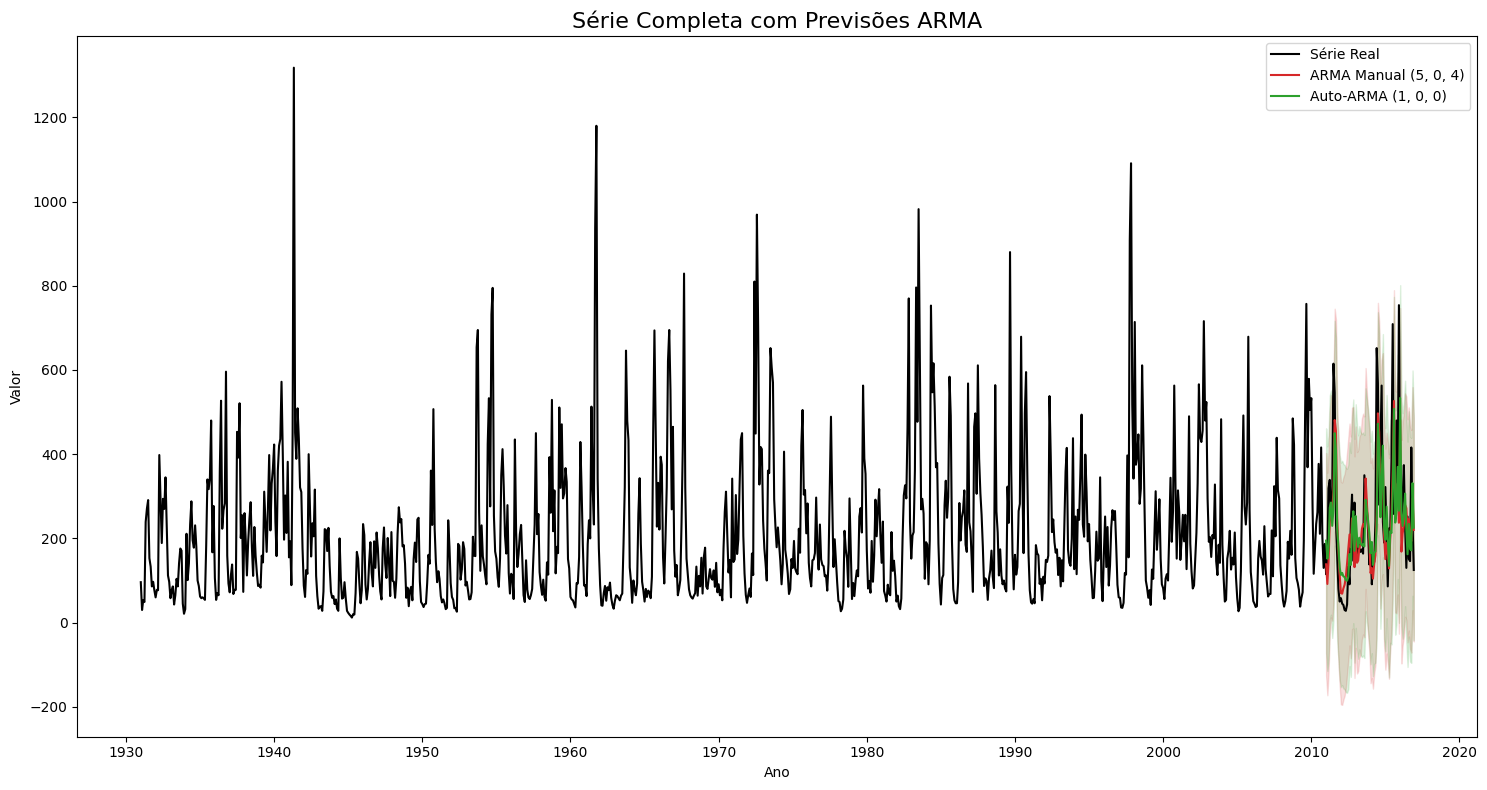

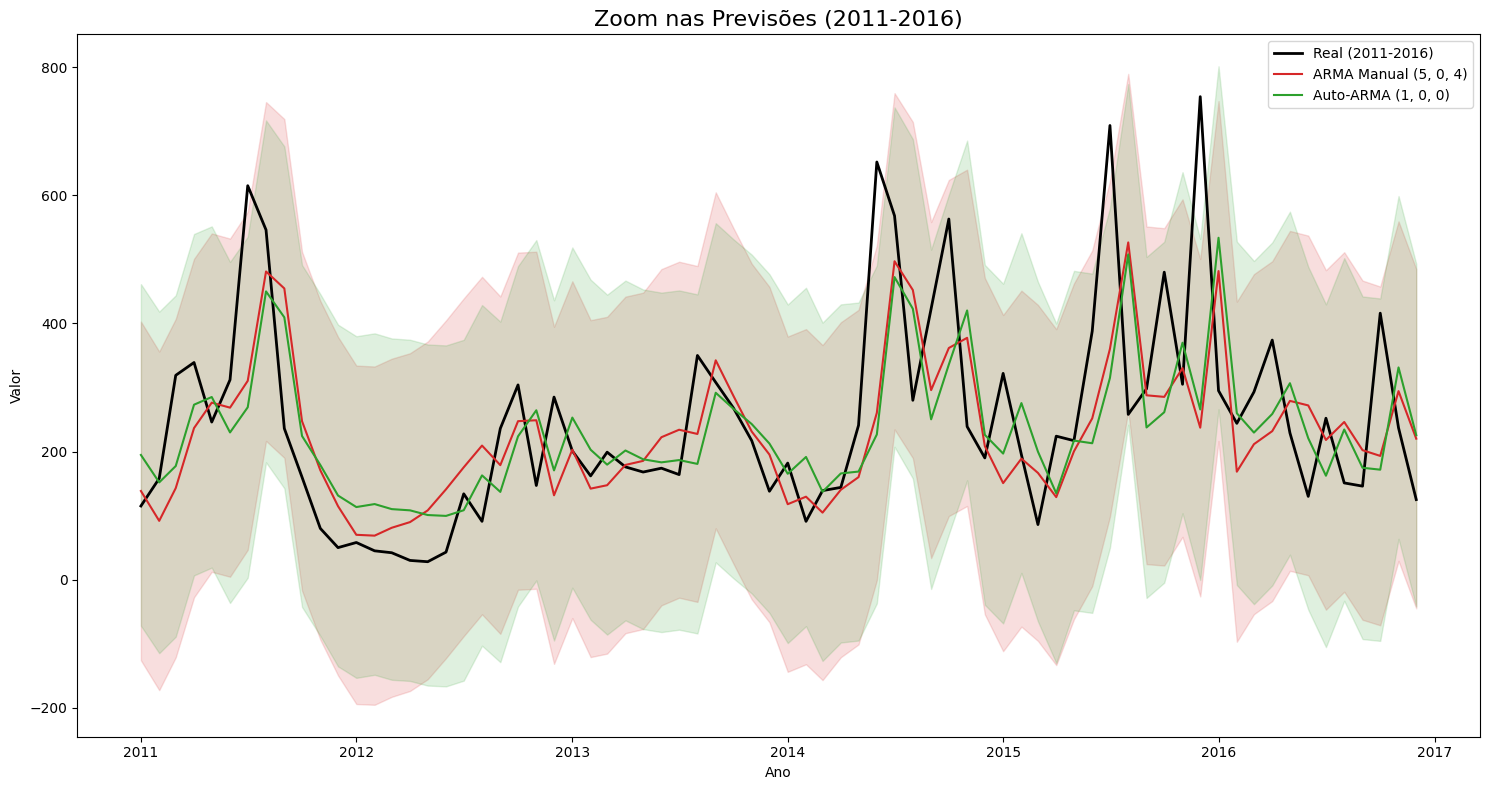

In [29]:
# %% --------------------------- 5. Plots
plt.figure(figsize=(15, 8))
plt.plot(full_series, label='Série Real', color='black')
plt.plot(manual_pred, label=f'ARMA Manual {manual_order}', color='tab:red')
plt.fill_between(manual_pred.index, manual_low, manual_up, color='tab:red', alpha=0.15)
plt.plot(auto_pred,  label=f'Auto-ARMA {auto_order}',  color='tab:green')
plt.fill_between(auto_pred.index,  auto_low,  auto_up,  color='tab:green', alpha=0.15)

plt.title('Série Completa com Previsões ARMA', fontsize=16)
plt.xlabel('Ano'); plt.ylabel('Valor'); plt.legend(); plt.tight_layout(); plt.show()

# Zoom 2011-2016
plt.figure(figsize=(15, 8))
plt.plot(test_series, label='Real (2011-2016)', color='black', linewidth=2)
plt.plot(manual_pred, label=f'ARMA Manual {manual_order}', color='tab:red')
plt.fill_between(manual_pred.index, manual_low, manual_up, color='tab:red', alpha=0.15)
plt.plot(auto_pred,  label=f'Auto-ARMA {auto_order}',  color='tab:green')
plt.fill_between(auto_pred.index,  auto_low,  auto_up,  color='tab:green', alpha=0.15)

plt.title('Zoom nas Previsões (2011-2016)', fontsize=16)
plt.xlabel('Ano'); plt.ylabel('Valor'); plt.legend(); plt.tight_layout(); plt.show()

## 10.2. ARIMA Pós Ajuste

In [12]:
# -----------------------------------------------------------
# 0) Pré-requisitos
# -----------------------------------------------------------
import warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Silencia avisos chatos
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
# -----------------------------------------------------------
# 1) Prepara o dataframe exatamente como antes
# -----------------------------------------------------------
df_model = df.copy()
df_model['DATE'] = pd.to_datetime(df_model['DATE'], format='%Y-%m')
df_model.set_index('DATE', inplace=True)
df_model.index = pd.DatetimeIndex(df_model.index.values, freq='MS')

train_start, train_end = '1931-01-01', '2010-12-01'
test_start,  test_end  = '2011-01-01', '2016-12-01'

train = df_model['VALUE'][train_start:train_end]
test  = df_model['VALUE'][test_start:test_end]

In [38]:
# -----------------------------------------------------------
# 2) Função auxiliar: walk-forward para ARIMA do statsmodels
# -----------------------------------------------------------
def rolling_arima(train_series, test_series, order=(1,1,2), alpha=0.05):
    history = train_series.copy()        # série que cresce mês a mês
    preds, lowers, uppers = [], [], []

    for t in test_series.index:
        # ajusta usando TODO o histórico disponível
        model = ARIMA(history, order=order).fit()
        fc_obj = model.get_forecast(steps=1)
        preds.append(fc_obj.predicted_mean.iloc[0])
        conf_int = fc_obj.conf_int(alpha=alpha).iloc[0]
        lowers.append(conf_int[0])   # limite inferior
        uppers.append(conf_int[1])   # limite superior

        # empurra o valor real desse mês para dentro do histórico
        history = pd.concat([history, pd.Series(test_series.loc[t], index=[t])])

    idx = test_series.index
    return (pd.Series(preds,  index=idx, name='pred'),
            pd.Series(lowers, index=idx, name='lower'),
            pd.Series(uppers, index=idx, name='upper'))

# -----------------------------------------------------------
# 3) Função auxiliar: walk-forward para auto_arima do pmdarima
# -----------------------------------------------------------
def rolling_auto_arima(train_series, test_series,
                       start_p=0, start_q=0, start_d = 1, max_p=5, max_q=5, max_d=5,
                       m=12, seasonal=False, alpha=0.05):

    # ajusta o 1º modelo só com o treino clássico
    auto_model = pm.auto_arima(
        train_series,
        start_p=start_p, start_q=start_q, start_d=start_d, d=start_d,
        max_p=max_p, max_q=max_q, max_d=max_d,
        seasonal=seasonal, m=m,
        test='adf', stepwise=True,
        error_action='ignore', suppress_warnings=True)

    history = train_series.copy()
    preds, lowers, uppers = [], [], []

    for t in test_series.index:
        # re-treina incrementalmente (evita procurar tudo de novo)
        auto_model.update(pd.Series(test_series.loc[t], index=[t]), refit=False)

        fc, ci = auto_model.predict(n_periods=1, return_conf_int=True, alpha=alpha)
        preds.append(fc[0])
        lowers.append(ci[0, 0])
        uppers.append(ci[0, 1])

        history = pd.concat([history, pd.Series(test_series.loc[t], index=[t])])

    idx = test_series.index
    return (pd.Series(preds,  index=idx, name='pred'),
            pd.Series(lowers, index=idx, name='lower'),
            pd.Series(uppers, index=idx, name='upper'),
            auto_model)

# -----------------------------------------------------------
# 4) Executa os dois rollings
# -----------------------------------------------------------
manual_pred, manual_low, manual_up = rolling_arima(train, test, order=(1,1,2))
auto_pred,   auto_low,   auto_up,  final_auto_model = rolling_auto_arima(train, test)

print("auto_arima final escolhido:", final_auto_model.order)

auto_arima final escolhido: (0, 1, 2)


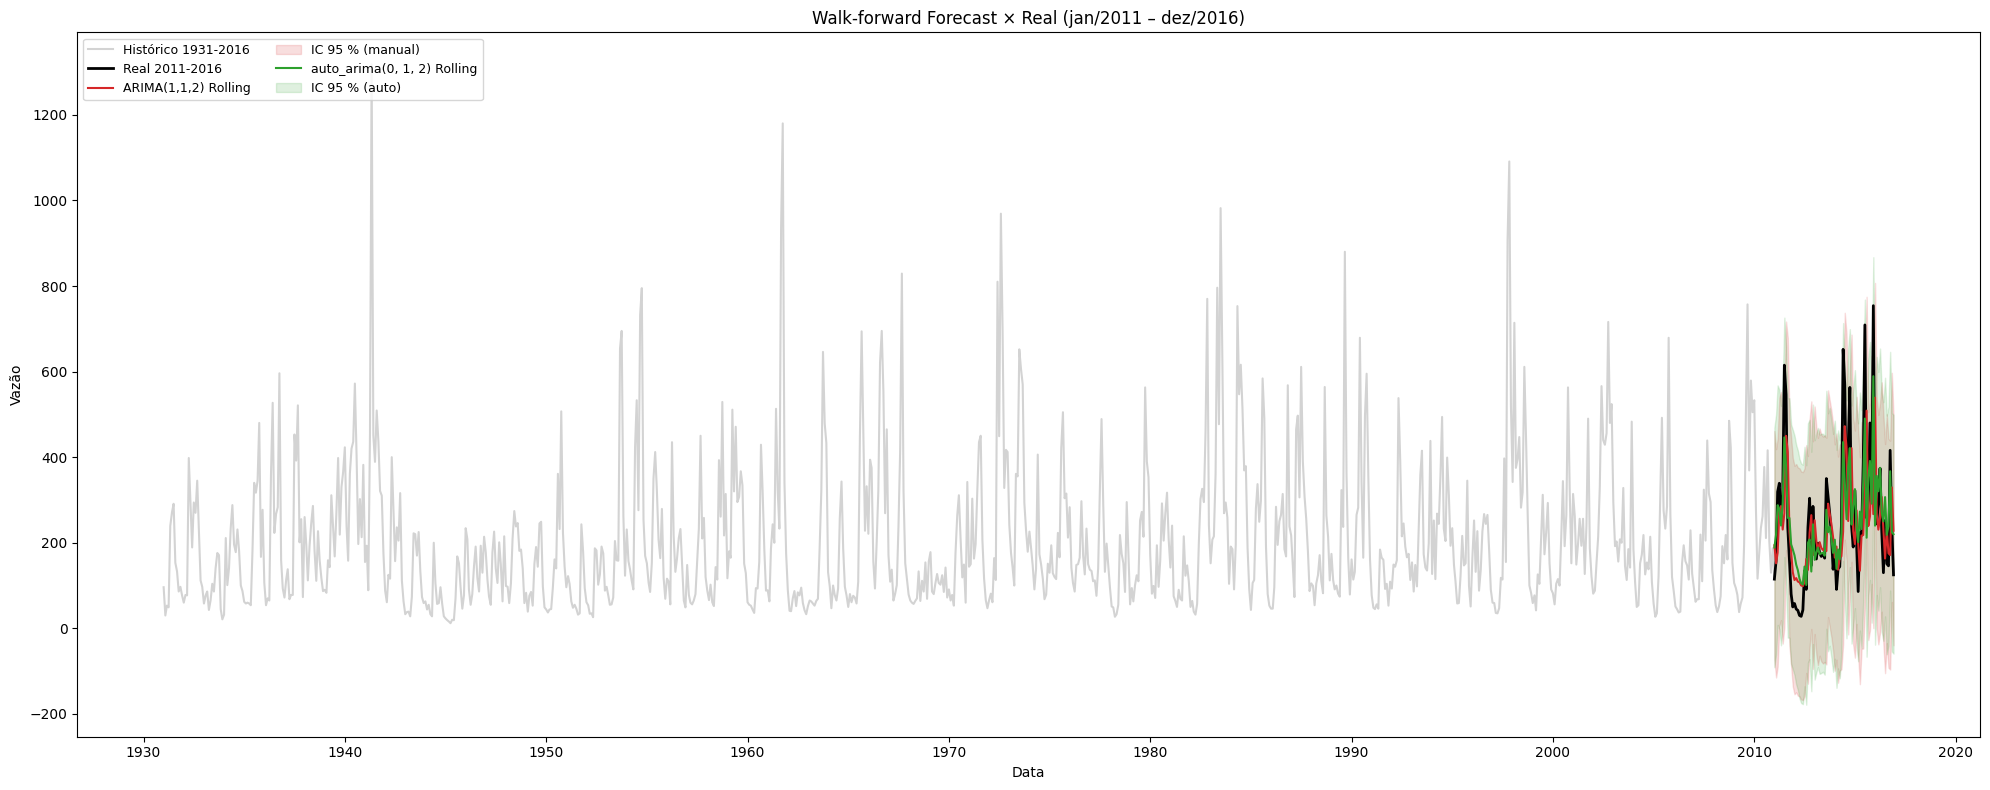

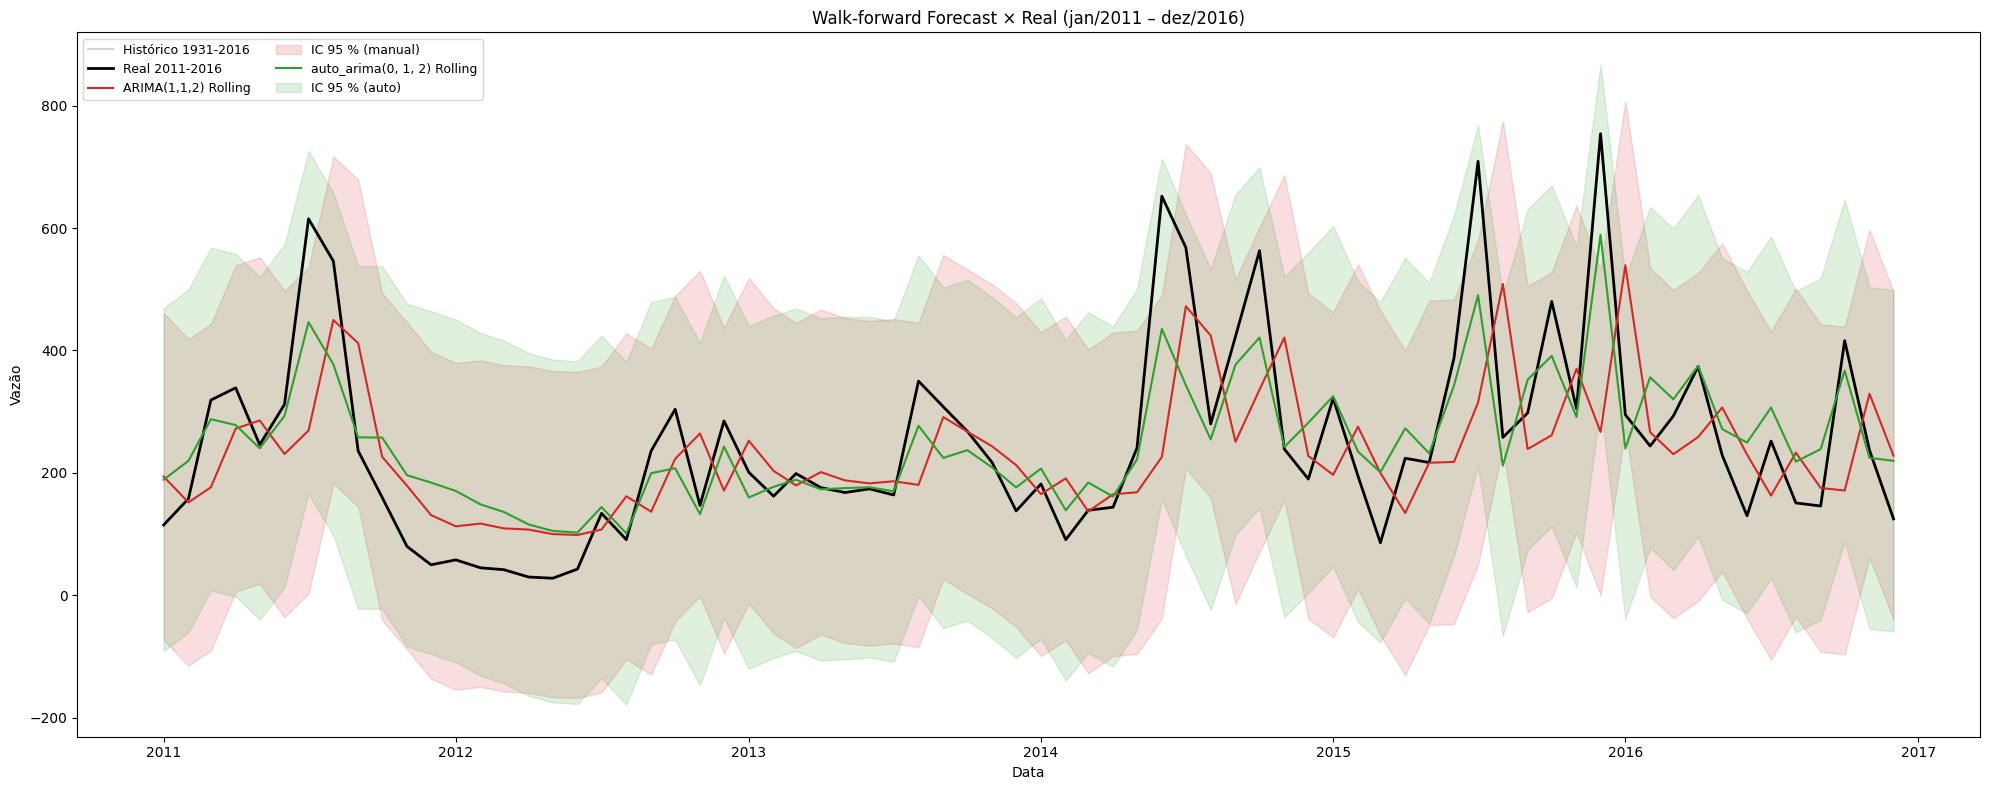

In [39]:
# -----------------------------------------------------------
# 5) Gráfico Previsão x Real
# -----------------------------------------------------------
plt.figure(figsize=(20,8))
# histórico completo
plt.plot(df_model['VALUE'], color='lightgray', label='Histórico 1931-2016')
# janela de teste real
plt.plot(test, color='black', linewidth=2, label='Real 2011-2016')

# forecasts MANUAL ARIMA
plt.plot(manual_pred, color='tab:red', label='ARIMA(1,1,2) Rolling')
plt.fill_between(manual_pred.index, manual_low, manual_up,
                 color='tab:red', alpha=0.15, label='IC 95 % (manual)')

# forecasts AUTO ARIMA
plt.plot(auto_pred, color='tab:green', label=f'auto_arima{final_auto_model.order} Rolling')
plt.fill_between(auto_pred.index, auto_low, auto_up,
                 color='tab:green', alpha=0.15, label='IC 95 % (auto)')

plt.title('Walk-forward Forecast × Real (jan/2011 – dez/2016)')
plt.xlabel('Data'); plt.ylabel('Vazão')
plt.legend(loc='upper left', ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 5) Gráfico Previsão x Real (somente 2011 em diante)
# -----------------------------------------------------------
plt.figure(figsize=(20,8))
# histórico completo
plt.plot(df_model['VALUE'].loc['2011-01-01':], color='lightgray', label='Histórico 1931-2016')
# janela de teste real
plt.plot(test, color='black', linewidth=2, label='Real 2011-2016')

# forecasts MANUAL ARIMA
plt.plot(manual_pred, color='tab:red', label='ARIMA(1,1,2) Rolling')
plt.fill_between(manual_pred.index, manual_low, manual_up,
                 color='tab:red', alpha=0.15, label='IC 95 % (manual)')

# forecasts AUTO ARIMA
plt.plot(auto_pred, color='tab:green', label=f'auto_arima{final_auto_model.order} Rolling')
plt.fill_between(auto_pred.index, auto_low, auto_up,
                 color='tab:green', alpha=0.15, label='IC 95 % (auto)')

plt.title('Walk-forward Forecast × Real (jan/2011 – dez/2016)')
plt.xlabel('Data'); plt.ylabel('Vazão')
plt.legend(loc='upper left', ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

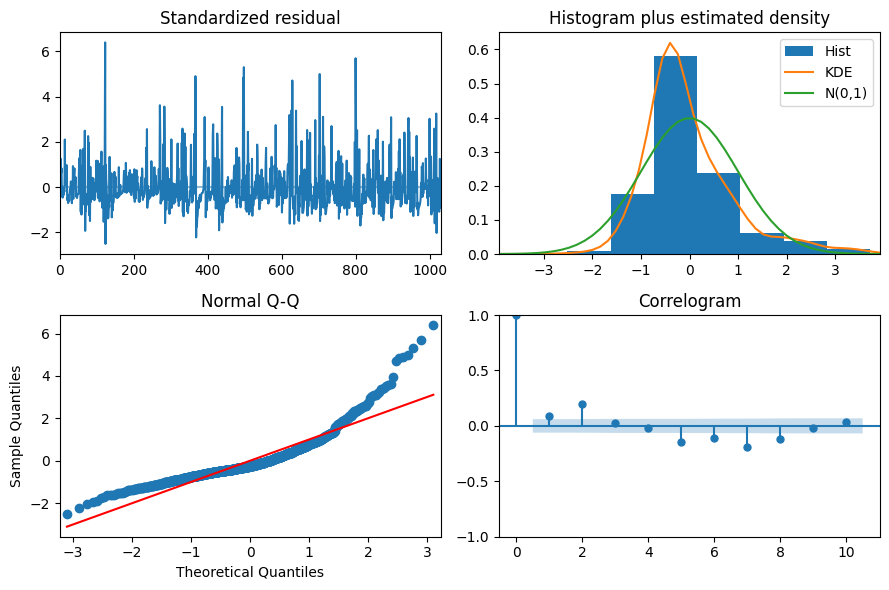

In [40]:
# Diagnóstico completo do auto_arima
final_auto_model.plot_diagnostics(figsize=(9, 6))
plt.tight_layout()
plt.show()

## 10.3. SARIMA Pós Ajuste

# 11. Comparação dos Modelos